In [1]:
using Pkg
Pkg.activate("C:/Users/ibzja/Documents/UPF_2022_2026/4t/2n_trimestre/Practiques_tutelades/CellBasedModels.jl")
using CellBasedModels 
using GeometryBasics
using Distributions
using GLMakie
Makie.inline!(true)

  Activating project at `C:\Users\ibzja\Documents\UPF_2022_2026\4t\2n_trimestre\Practiques_tutelades\CellBasedModels.jl`


true

Change Yp equation to the one taking into acount phosphorylation rate. 

In [ ]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :v => Float64,  #Swimming speed
        :theta => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        :active => Bool,

        :methyl => Float64, #Receptor methylation
        :Yp => Float64, #CheYP levels, probability of tumblingç
        :G => Float64,
        :λ => Float64,
        :P => Float64,
        :M => Float64,
        :mm => Float64,
        :F => Float64,
        :A => Float64
        
    ),

    model = Dict(

        :Dr_run => Float64,

        :ε0 => Float64, #Energy parameters
        :ε1 => Float64,
        :ε2 => Float64,
        :ε3 => Float64,
        :K => Float64,
        :Nrec => Float64, #Cooperativity
        :Ki => Float64, #Dissociation constants
        :Ka => Float64,
        :τm => Float64, #Methylation adaptation timescale
        # :Yp0 => Float64,   #CheYP adapted = K
        :α => Float64,      #Total Yp pool
        :ωFrec => Float64,     #Basal switching frequency
        :Ky => Float64,         #CheA - CheY phosphorylation rate
        :Z => Float64,          #CheZ concentration
        :Kz => Float64,         #CheZ mediated dephosphorylation rate
        :Yy => Float64,         #Basa Yp leak
    ),

    # medium = Dict(
    #     :mm => Float64
    # ),

    agentODE = quote

    
        mm = 0.02*exp(x*30^(-1))
        # mm = 0.02*exp(x*30^(-3))
        # mm = 0.02*exp(x*30^(-5))
    

        F = ε0 + ε1 * methyl + Nrec * log((1 + mm / Ki) / (1 + mm / Ka)) #Equació del paper per definir activitat del receptor
        F0 = log(((Ky * (α - K)) / (K * (Kz * Z + Yy))) - 1)        #Energia lliure en estat adaptat

        mx = (ε0 + Nrec * log((1 + mm / Ki) / (1 + mm / Ka)) - F0) / (- ε1)

        A = 1 / (1 + exp(F))    

        Yp = (Ky * A * α) / ((Ky * A) + (Kz * Z) + Yy)

        G = ε2 / 4 - (ε3 / 2) / (1 + (K / Yp))      #CheYp segons activitat receptor

        dt(x) = active * vx  #Change position acording to constant speed afected by forces
        dt(y) = active * vy  
        dt(methyl) = -(1 / τm) * (methyl - mx)        #Methylation
        
    end,

    agentRule = quote


        if active 
            λ = ωFrec*exp(-G)*dt 
            P = 1 - exp(-λ * dt)
            
        else
            λ = ωFrec*exp(G)*dt 
            P = 1 - exp(-λ * dt)  
            
        end


        if active 
            λrt = ωFrec*exp(-G)*dt 
            P_rt = 1 - exp(-λrt * dt)
            P = rand() 
            # if P < λrt               #Si rate alta = mes probabilitat de canvi. Per tant, si random number mes petit =  canvi. 
            if P < P_rt             #Si rate alta = mes probabilitat de canvi. Per tant, si random number mes petit =  canvi. 
                active = false
                vx = 0
                vy = 0
                theta = rand(Uniform(0, 2π))            #Tumble = random reorientation
            else     #Si rate baixa 
                active = true
                vx = v * cos(theta)
                vy = v * sin(theta)
                theta += sqrt(2 * Dr_run * dt) * randn()        #Keep running, reorientation according to rotational difusion
            end

        elseif !active
            λtr = ωFrec*exp(G) *dt
            P_tr = 1 - exp(-λtr * dt)
            P = rand()
            # if P < λtr 
            if P < P_tr
                active = true
                vx = v * cos(theta)
                vy = v * sin(theta)
                theta += sqrt(2 * Dr_run * dt) * randn()
            else
                active = false
                vx = 0
                vy = 0
                theta = rand(Uniform(0, 2π))
            end
            
        end
 
        # if x < simBox[1,1]
        #     x = simBox[1,1]
        #     theta = pi - theta      #Avoid stuck in wall
        # elseif x > simBox[1,2]
        #     x = simBox[1,2]
        #     theta = pi - theta
        # end
        # if y < simBox[2,1]
        #     y = simBox[2,1]
        #     theta = -theta
        # elseif y > simBox[2,2]
        #     y = simBox[2,2]
        #     theta = -theta
        # end

    end,

    # mediumODE = quote
    #     if @mediumInside()
    #         dt(mm) = 0.02*exp((x - com.simBox[1,1])*30^(-3 ))
    #     end
    # end,

    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)

PARAMETERS
	x (Float64 agent)
	y (Float64 agent)
	M (Float64 agent)
	d (Float64 agent)
	active (Bool agent)
	v (Float64 agent)
	λ (Float64 agent)
	F (Float64 agent)
	fx (Float64 agent)
	mm (Float64 agent)
	A (Float64 agent)
	methyl (Float64 agent)
	vx (Float64 agent)
	l (Float64 agent)
	m (Float64 agent)
	fy (Float64 agent)
	Yp (Float64 agent)
	P (Float64 agent)
	pressure (Float64 agent)
	vy (Float64 agent)
	W (Float64 agent)
	G (Float64 agent)
	theta (Float64 agent)
	ε1 (Float64 model)
	α (Float64 model)
	Z (Float64 model)
	Dr_run (Float64 model)
	Ka (Float64 model)
	ε3 (Float64 model)
	ε0 (Float64 model)
	Ky (Float64 model)
	Kz (Float64 model)
	K (Float64 model)
	ε2 (Float64 model)
	Nrec (Float64 model)
	τm (Float64 model)
	Yy (Float64 model)
	Ki (Float64 model)
	ωFrec (Float64 model)


UPDATE RULES
agentRule
 begin
    if active
        λ__ = ωFrec * exp(-G) * dt
        P__ = 1 - exp(-λ * dt)
    else
        λ__ = ωFrec * exp(G) * dt
        P__ = 1 - exp(-λ * dt)
    end
    if a

In [ ]:
com = Community(
    rods2DChemotaxis,
    N=100,
    dt=0.1,
    simBox=[0 40; 0 40.],  #change box
    NMedium=[200, 200],
)

m = 1/100
g = 1/10000
d = 1

com.Dr_run = 0.062

com.v = 20.0

com.ωFrec = 1.3
com.Ki = 0.0182
com.Ka = 3.0
com.Nrec = 6.0
com.ε0   = 6.0
com.ε1   = -1.0
com.ε2   = 80
com.ε3   = 80
com.τm = 30.0
# com.τm = 5.0
# com.τm = 10.0
com.α   = 6.0

com.K = 2.0 

com.Ky = 100.0
com.Kz = 10.0
com.Z = 5.0
com.Yy = 0.1

com.m = 1.        
com.d = 1.        
com.l = 3;

com.x = rand(Uniform(com.simBox[1,:]...),com.N)
com.y = rand(Uniform(com.simBox[2,:]...),com.N)
com.theta = rand(Uniform(0,2π),com.N)

com.methyl .= 0.0
com.Yp .= com.K

com.active = true

0.0:0.20100502512562815:40.0

In [165]:
using CSV, DataFrames

outfile = "cell_model_Justin_8.csv"
data = DataFrame(
    step = Int[],
    id = Int[],
    x = Float64[],
    y = Float64[],
    active = Bool[],
    λ = Float64[],
    G = Float64[], 
    P = Float64[],
    M = Float64[],   
    Yp = Float64[],
    methyl = Float64[],
    F = Float64[]
)



steps = 50000
loadToPlatform!(com, preallocateAgents=100)       #Preallocate agents = number of agents in community


for step in 1:steps
    step!(com)
    for i in 1:com.N
        push!(data, (
            step, 
            i,
            com.x[i],
            com.y[i],
            com.active[i],
            com.λ[i],
            com.G[i],
            com.P[i],
            com.mm[i],
            com.Yp[i],
            com.methyl[i],
            com.F[i]
        ))
    end
end

CSV.write(outfile, data)

"cell_model_Justin_8.csv"

Test2 = he posat 50000 steps per fer els 500s igual que al paper. Posar la concentració del medi com al paper no funciona, aixi que esta amb g = 30^(-1)<br>
Test2_2 = mateix codi, segon intent<br>
Test3 = g = 30^(-5) com posa al paper d'en justin = resultat semblant a L constant de Yp<br>
Test4 = g = 3<br>
Test5 = g = 3^(-3)


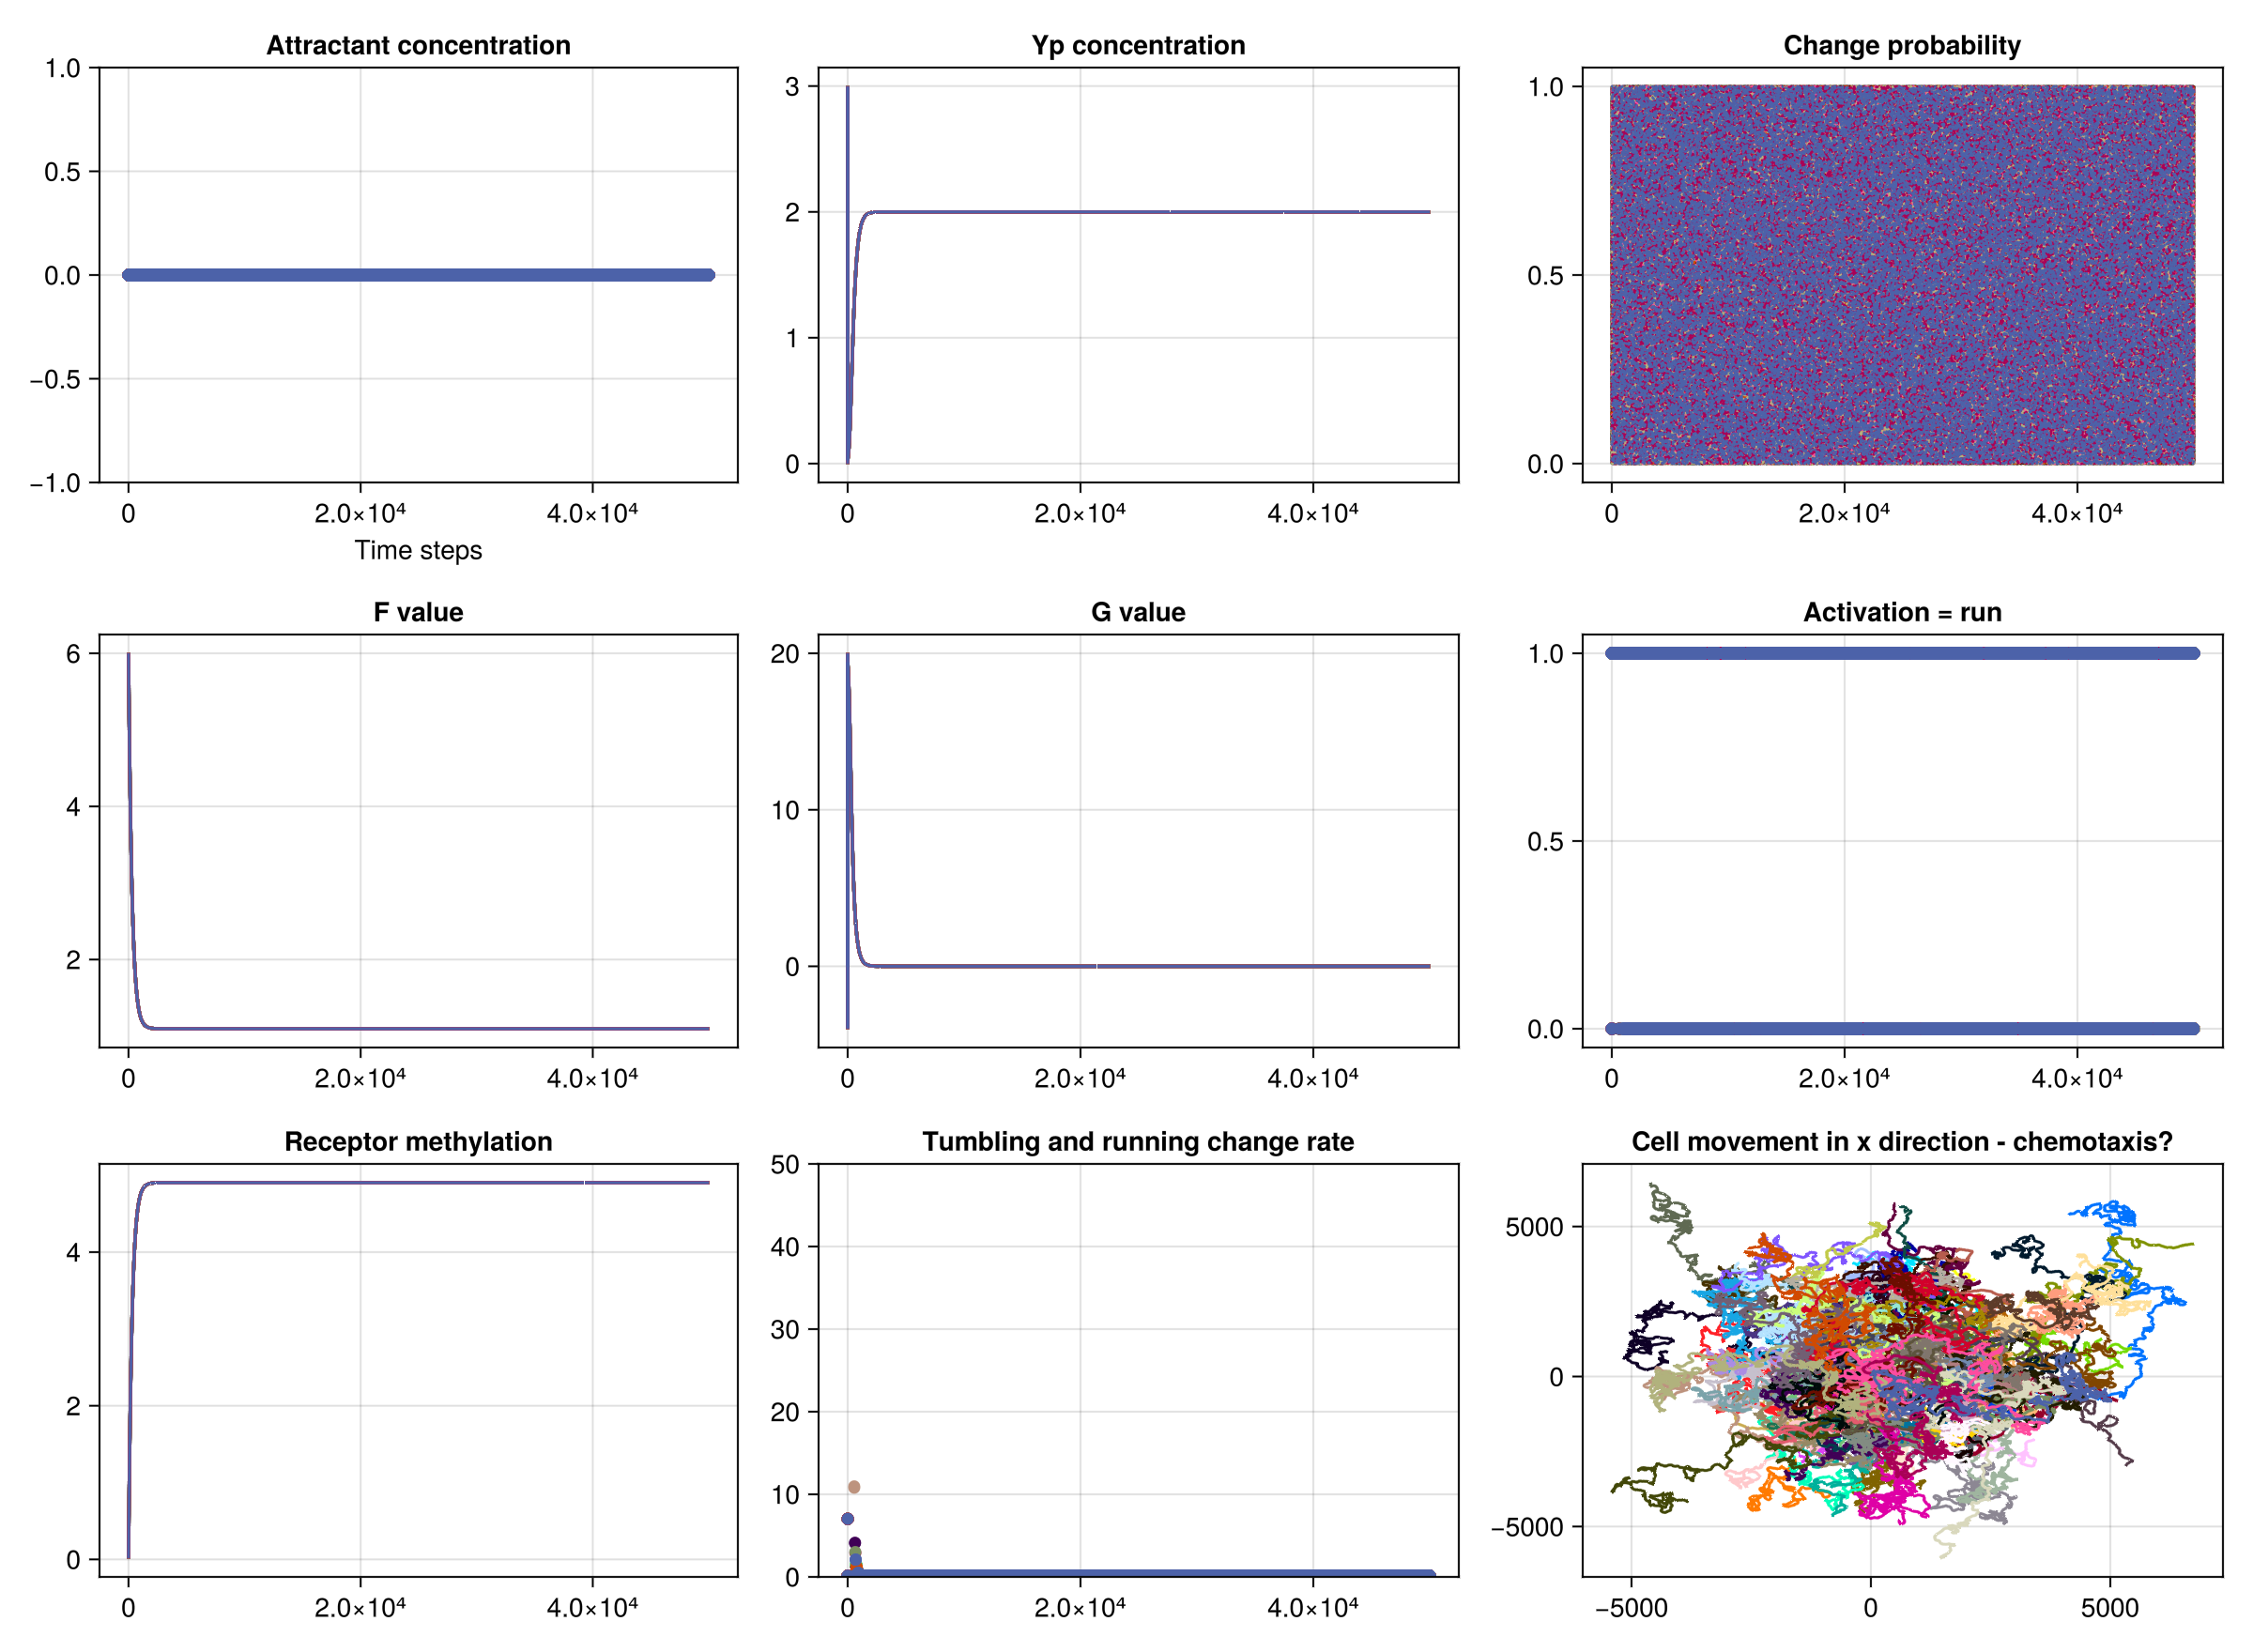

GLMakie.Screen(...)

In [166]:
fig = Figure(size = (1200, 2500))

# Get unique cell IDs
cell_ids = unique(data.id)
n_cells = length(cell_ids)

# Generate fixed, distinguishable colors (same for all plots)
colors = distinguishable_colors(n_cells, [RGBf(0.2, 0.2, 0.2)], dropseed = true)

# Map id → color
id_to_color = Dict(cell_ids .=> colors)

ax0 = Axis(fig[1,1], title = "Attractant concentration", xlabel = "Time steps")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    scatter!(ax0, group.step, group.M, color = id_to_color[id], label = "Cell $id")
end

# ylims!(ax0, 0.0, 10^30)

ax1 = Axis(fig[2,1], title = "F value" )

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    lines!(ax1, group.step, group.F, color = id_to_color[id], label = "Cell $id")
end


ax2 = Axis(fig[3,1], title = "Receptor methylation")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    lines!(ax2, group.step, group.methyl, color = id_to_color[id], label = "Cell $id")
end

ax3 = Axis(fig[1,2], title = "Yp concentration")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    lines!(ax3, group.step, group.Yp, color = id_to_color[id], label = "Cell $id")
end

ax4 = Axis(fig[2,2], title = "G value")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    lines!(ax4, group.step, group.G, color = id_to_color[id], label = "Cell $id")
end

ax5 = Axis(fig[3,2], title = "Tumbling and running change rate")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    scatter!(ax5, group.step, group.λ, color = id_to_color[id], label = "Cell $id")
end

ylims!(ax5, 0.0, 50)

ax6 = Axis(fig[1,3], title = "Change probability")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    scatter!(ax6, group.step, group.P, color = id_to_color[id], label = "Cell $id", markersize = 2)
end

ax6 = Axis(fig[2,3], title = "Activation = run")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    scatter!(ax6, group.step, group.active, color = id_to_color[id], label = "Cell $id")
end

ax7 = Axis(fig[3,3], title = "Cell movement in x direction - chemotaxis?")

for (groupkey, group) in pairs(groupby(data, :id))
    id = groupkey.id
    lines!(ax7, group.x, group.y, color = id_to_color[id], label = "Cell $id")
end


display(fig)

In [155]:
save("justin_8.png", fig)

Imatge 3 = gradient que indica g = 30^(-5)  --> el grafic Yp s'asembla molt al primer paper, quan L es constant --> feedback funciona?

In [2]:
using CSV, DataFrames
data = CSV.read("cell_model_Justin_2.csv", DataFrame)

Row,step,id,x,y,active,λ,G,P,M,Yp,methyl,F
,Int64,Int64,Float64,Float64,Bool,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,37.3614,1.21024,false,0.13,0.0,0.571662,0.838712,0.0,0.0163468,6.0
2,1,2,13.7831,25.046,false,0.13,0.0,0.285665,0.0793638,0.0,0.0163468,6.0
3,1,3,6.91704,34.9865,false,0.13,0.0,0.606051,0.0399423,0.0,0.0163468,6.0
4,1,4,7.18659,6.97129,false,0.13,0.0,0.919768,0.0410336,0.0,0.0163468,6.0
5,1,5,29.8436,1.7791,false,0.13,0.0,0.553389,0.395477,0.0,0.0163468,6.0
6,1,6,3.30497,24.8862,false,0.13,0.0,0.270052,0.0278332,0.0,0.0163468,6.0
7,1,7,30.8401,35.3679,false,0.13,0.0,0.0835338,0.436917,0.0,0.0163468,6.0
8,1,8,29.4685,39.0128,false,0.13,0.0,0.0161863,0.380916,0.0,0.0163468,6.0
9,1,9,27.3654,13.6941,false,0.13,0.0,0.990099,0.30867,0.0,0.0163468,6.0


In [3]:
#Group by step
grouped = groupby(data, :step)

#Compute mean and SEM
ensemble = combine(grouped,
    :Yp => mean => :Yp_mean,
    :Yp => std => :Yp_std,
    :F => mean => :F_mean,
    :F => std => :F_std,
    :methyl => mean => :methyl_mean,
    :methyl => std => :methyl_std,
    :x => mean => :x_mean,
    :x => std => :x_std,
    :M => mean => :M_mean,
    :M => std => :M_std
)

# Step 3: Add SEM columns
N = length(unique(data.id))
ensemble.Yp_sem = ensemble.Yp_std ./ sqrt(N)
ensemble.F_sem = ensemble.F_std ./ sqrt(N)
ensemble.methyl_sem = ensemble.methyl_std ./ sqrt(N)
ensemble.x_sem = ensemble.x_std ./ sqrt(N)
ensemble.M_sem = ensemble.M_std ./ sqrt(N)

# Step 4: Add time vector (if step is in seconds)
ensemble.t = ensemble.step .* 0.01  # adjust if dt is different

50000-element Vector{Float64}:
   0.01
   0.02
   0.03
   0.04
   0.05
   0.06
   0.07
   0.08
   0.09
   0.1
   ⋮
 499.92
 499.93
 499.94
 499.95
 499.96000000000004
 499.97
 499.98
 499.99
 500.0

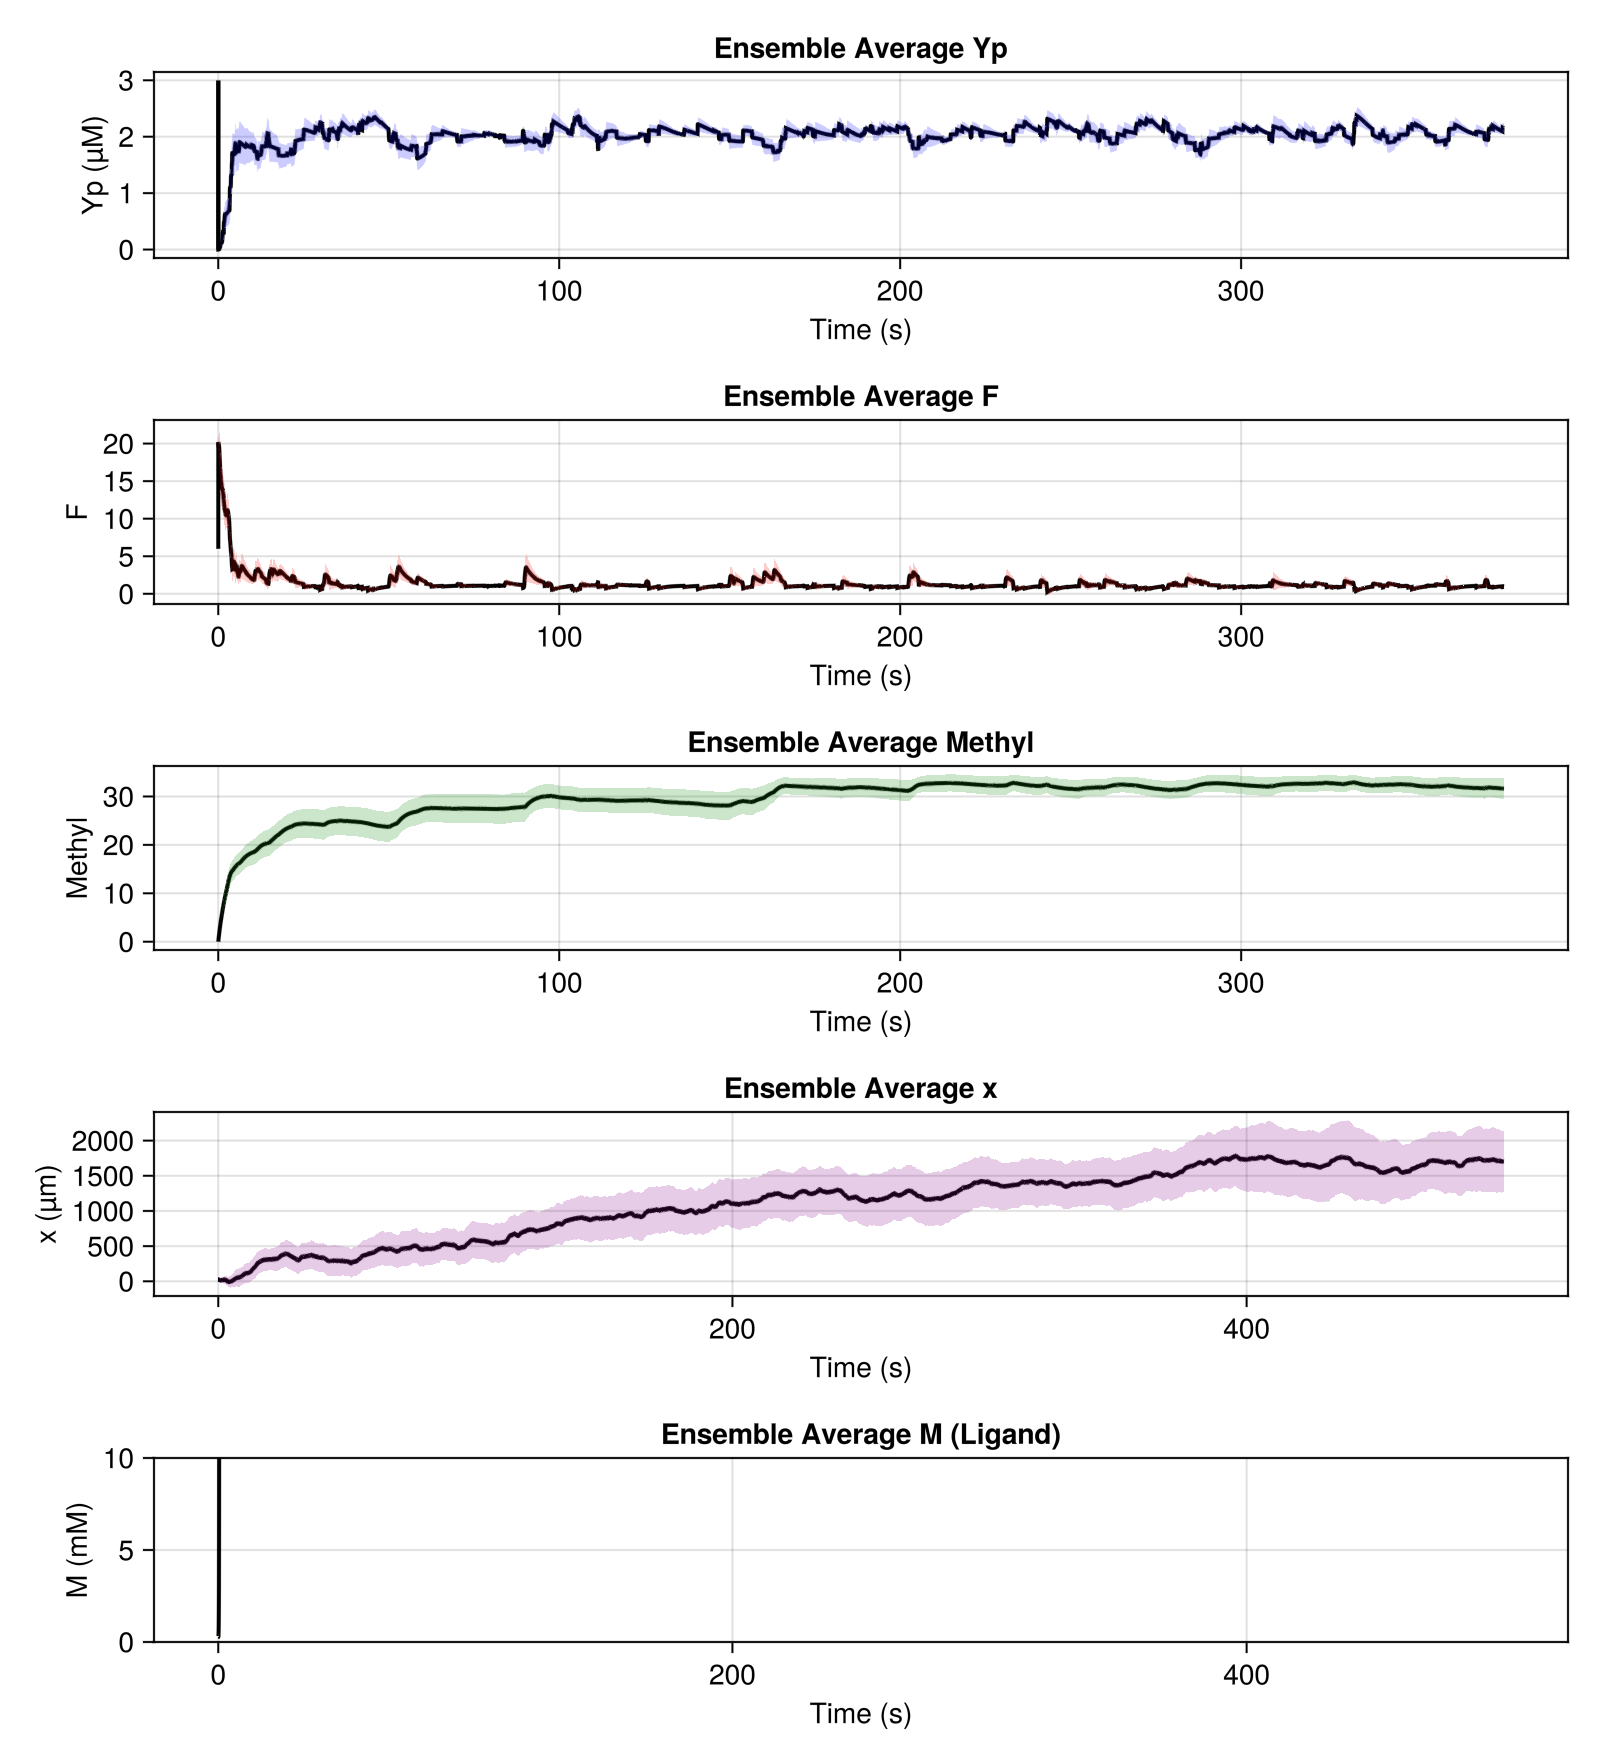

GLMakie.Screen(...)

In [4]:
fig = Figure(size=(800, 1000))

# Yp
ax1 = Axis(fig[1,1], title="Ensemble Average Yp", xlabel="Time (s)", ylabel="Yp (µM)")
lines!(ax1, ensemble.t, ensemble.Yp_mean, color=:black, linewidth=2)
band!(ax1, ensemble.t, ensemble.Yp_mean .- ensemble.Yp_sem, ensemble.Yp_mean .+ ensemble.Yp_sem, color=(:blue, 0.2))

# F
ax2 = Axis(fig[2,1], title="Ensemble Average F", xlabel="Time (s)", ylabel="F")
lines!(ax2, ensemble.t, ensemble.F_mean, color=:black, linewidth=2)
band!(ax2, ensemble.t, ensemble.F_mean .- ensemble.F_sem, ensemble.F_mean .+ ensemble.F_sem, color=(:red, 0.2))

# methyl
ax3 = Axis(fig[3,1], title="Ensemble Average Methyl", xlabel="Time (s)", ylabel="Methyl")
lines!(ax3, ensemble.t, ensemble.methyl_mean, color=:black, linewidth=2)
band!(ax3, ensemble.t, ensemble.methyl_mean .- ensemble.methyl_sem, ensemble.methyl_mean .+ ensemble.methyl_sem, color=(:green, 0.2))

# x (position)
ax4 = Axis(fig[4,1], title="Ensemble Average x", xlabel="Time (s)", ylabel="x (µm)")
lines!(ax4, ensemble.t, ensemble.x_mean, color=:black, linewidth=2)
band!(ax4, ensemble.t, ensemble.x_mean .- ensemble.x_sem, ensemble.x_mean .+ ensemble.x_sem, color=(:purple, 0.2))

# M (ligand concentration)
ax5 = Axis(fig[5,1], title="Ensemble Average M (Ligand)", xlabel="Time (s)", ylabel="M (mM)")
lines!(ax5, ensemble.t, ensemble.M_mean, color=:black, linewidth=2)
band!(ax5, ensemble.t, ensemble.M_mean .- ensemble.M_sem, ensemble.M_mean .+ ensemble.M_sem, color=(:orange, 0.2))

display(fig)


In [5]:
save("ensemble_average_2.png", fig)

In [11]:
using CSV, Distributions, DataFrames

data = CSV.read("cell_model_Justin_6.csv", DataFrame)
gr = groupby(data, :step)


Row,step,id,x,y,active,λ,G,P,M,Yp,methyl,F
,Int64,Int64,Float64,Float64,Bool,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,20.3237,1.70957,false,0.13,0.0,0.598958,0.0393773,0.0,0.0163468,6.0
2,1,2,11.1264,11.4656,false,0.13,0.0,0.511705,0.0289802,0.0,0.0163468,6.0
3,1,3,35.0301,33.1131,false,0.13,0.0,0.882864,0.0642898,0.0,0.0163468,6.0
4,1,4,20.8954,16.1652,false,0.13,0.0,0.530331,0.0401348,0.0,0.0163468,6.0
5,1,5,38.5973,39.3658,false,0.13,0.0,0.935348,0.0724074,0.0,0.0163468,6.0
6,1,6,39.7023,7.83855,false,0.13,0.0,0.143346,0.0751242,0.0,0.0163468,6.0
7,1,7,26.1213,22.9101,false,0.13,0.0,0.110356,0.0477722,0.0,0.0163468,6.0
8,1,8,37.33,29.9867,false,0.13,0.0,0.211941,0.0694124,0.0,0.0163468,6.0
9,1,9,25.0524,13.3458,false,0.13,0.0,0.0422186,0.0461,0.0,0.0163468,6.0


In [12]:
minimum(data.M), maximum(data.M)

(3.627003708545236e-106, 3.1879473834965196e103)

In [16]:
using Statistics, StatsBase

In [18]:
edges = range(minimum(data.M), maximum(data.M), length=11)
hist = fit(Histogram, data.M, edges)

Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  3.627003708545236e-106:3.1879473834965195e102:3.1879473834965196e103
weights: [4999869, 36, 16, 25, 13, 9, 7, 7, 6, 11]
closed: left
isdensity: false

In [19]:
freq_df = DataFrame(
    range = ["$(edges[i]) – $(edges[i+1])" for i in 1:length(edges)-1],
    count = hist.weights
)

Row,range,count
,String,Int64
1,3.627003708545236e-106 – 3.1879473834965195e102,4999869
2,3.1879473834965195e102 – 6.375894766993039e102,36
3,6.375894766993039e102 – 9.563842150489558e102,16
4,9.563842150489558e102 – 1.2751789533986078e103,25
5,1.2751789533986078e103 – 1.5939736917482598e103,13
6,1.5939736917482598e103 – 1.9127684300979116e103,9
7,1.9127684300979116e103 – 2.231563168447564e103,7
8,2.231563168447564e103 – 2.5503579067972156e103,7
9,2.5503579067972156e103 – 2.869152645146868e103,6


In [23]:
cutoff =3.1879473834965195e102
df_filtered = filter(:M => x -> x ≤ cutoff, data)

Row,step,id,x,y,active,λ,G,P,M,Yp,methyl,F
,Int64,Int64,Float64,Float64,Bool,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,20.3237,1.70957,false,0.13,0.0,0.598958,0.0393773,0.0,0.0163468,6.0
2,1,2,11.1264,11.4656,false,0.13,0.0,0.511705,0.0289802,0.0,0.0163468,6.0
3,1,3,35.0301,33.1131,false,0.13,0.0,0.882864,0.0642898,0.0,0.0163468,6.0
4,1,4,20.8954,16.1652,false,0.13,0.0,0.530331,0.0401348,0.0,0.0163468,6.0
5,1,5,38.5973,39.3658,false,0.13,0.0,0.935348,0.0724074,0.0,0.0163468,6.0
6,1,6,39.7023,7.83855,false,0.13,0.0,0.143346,0.0751242,0.0,0.0163468,6.0
7,1,7,26.1213,22.9101,false,0.13,0.0,0.110356,0.0477722,0.0,0.0163468,6.0
8,1,8,37.33,29.9867,false,0.13,0.0,0.211941,0.0694124,0.0,0.0163468,6.0
9,1,9,25.0524,13.3458,false,0.13,0.0,0.0422186,0.0461,0.0,0.0163468,6.0


In [28]:
cutoff = quantile(data.M, 0.95)

1.3332049683794934e56

In [30]:
q1, q3 = quantile(data.M, [0.25, 0.75])
iqr = q3 - q1
cutoff = q3 + 1.5 * iqr

6.143934723988245e28

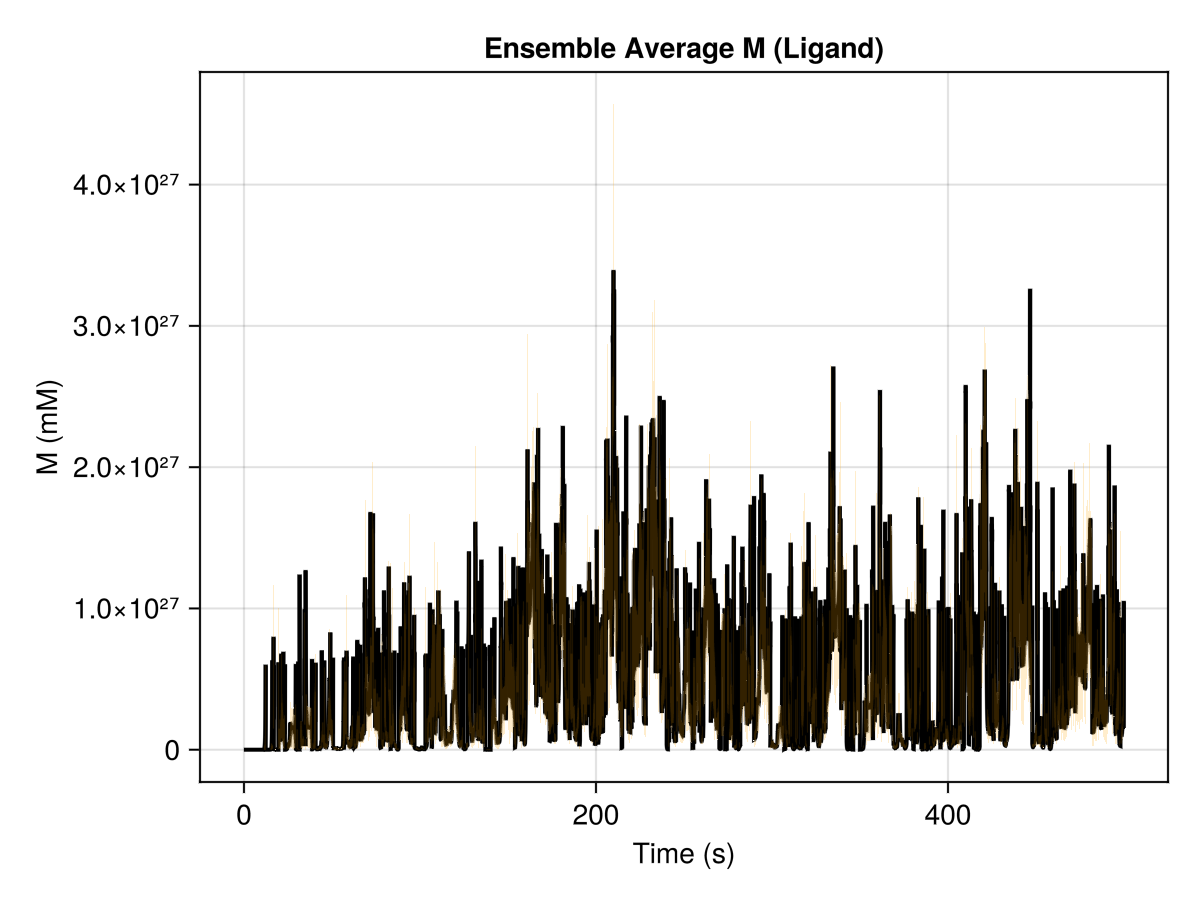

GLMakie.Screen(...)

In [31]:
df_filtered = filter(:M => x -> x ≤ cutoff, data)
gr = groupby(df_filtered, :step)
ensemble = combine(gr,
    :M => mean => :M_mean,
    :M => std => :M_std)
    
N = length(unique(df_filtered.id))
ensemble.M_sem = ensemble.M_std ./ sqrt(N)
ensemble.t = ensemble.step .* 0.01 


fig2 = Figure()
ax5 = Axis(fig2[1,1], title="Ensemble Average M (Ligand)", xlabel="Time (s)", ylabel="M (mM)")
lines!(ax5, ensemble.t, ensemble.M_mean, color=:black, linewidth=2)
band!(ax5, ensemble.t, ensemble.M_mean .- ensemble.M_sem, ensemble.M_mean .+ ensemble.M_sem, color=(:orange, 0.2))

display(fig2)